## Import all libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import re
from itertools import chain
import warnings

import spacy
spacy.cli.download("en_core_web_sm")

import gender_guesser.detector as gender

from allennlp.predictors.predictor import Predictor
model_url = "https://storage.googleapis.com/allennlp-public-models/coref-spanbert-large-2020.02.27.tar.gz"
predictor = Predictor.from_path(model_url)

import textacy

data_folder = 'data/'

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


error loading _jsonnet (this is expected on Windows), treating C:\Users\alexi\AppData\Local\Temp\tmp5iyzbmnf\config.json as plain json


In [4]:
##Only for me 
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Table of contents
1. [Load CMU Movie Summary Corpus data](#loadCMU)
2. [Data exploration of the movie metadata](#movie)
    1. [Sub paragraph](#subparagraph1)
3. [Data exploration of the character metadata](#character)
4. [Data exploration of summaries](#summary)
5. [Summaries analysis pipeline](#pipeline)
    1. [Coreference resoltion using AllenNLP model](#coref)
    2. [Indentification of characters in the summary](#NER)

Blabla introduce what we are doing here 

# Load CMU Movie Summary Corpus <a name="loadCMU"></a>

## Movies Metadata

In [5]:
#Load data and set indexes
movie_metadata = pd.read_csv(data_folder + "movie.metadata.tsv", sep='\t', header = None)
movie_metadata.columns = ['movie_ID','FB_ID','movie_name','release_date','box_office','length','languages','country','genres']

#Force float type to the movie ID column, set as index
movie_metadata.movie_ID = movie_metadata.movie_ID.astype(int)
movie_metadata = movie_metadata.set_index('movie_ID')

#Drop freebase database ID, we don't need it
movie_metadata = movie_metadata.drop(columns=['FB_ID'])

#Remove movies with non-defined release date
#Convert release date to datetime type, only keep year 
movie_metadata = movie_metadata[movie_metadata.release_date.notna()]
movie_metadata['release_date'] = movie_metadata.release_date.apply(lambda d:datetime.strptime(str(d[0:4]), "%Y"))
movie_metadata['release_date'] = [date.year for date in movie_metadata.release_date]

#Change release date 1010, it's a mistake movie actually release in 2010
movie_metadata = movie_metadata.replace(1010,2010)

#Clean languages, country, genres columns
movie_metadata['languages'] = [lang.split('"')[3::4] for lang in movie_metadata.languages]
movie_metadata['country'] = [lang.split('"')[3::4] for lang in movie_metadata.country]
movie_metadata['genres'] = [lang.split('"')[3::4] for lang in movie_metadata.genres]

movie_metadata.head(10)

,movie_name,release_date,box_office,length,languages,country,genres
movie_ID,,,,,,,
975900,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
28463795,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
9363483,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
261236,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama]
13696889,The Gangsters,1913,NaN,35.0,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Indie, Black-and-whi..."
18998739,The Sorcerer's Apprentice,2002,NaN,86.0,[English Language],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]"
10408933,Alexander's Ragtime Band,1938,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]"
9997961,Contigo y aquí,1974,NaN,NaN,[Spanish Language],[Argentina],"[Musical, Drama, Comedy]"


## Characters metadata

In [6]:
#Load character metadata
character_metadata = pd.read_csv(data_folder + "character.metadata.tsv", sep='\t', header=None)

#only keep movie_ID , name, gender, and age
character_metadata = character_metadata.iloc[:,[0,2,3,5,9]] 
character_metadata.columns = ['movie_ID','release_date','name','gender','age']
character_metadata.name = character_metadata['name'].astype(str)
character_metadata.movie_ID = character_metadata['movie_ID'].astype(int)
character_metadata = character_metadata.set_index('movie_ID')

#Change realease year to float indicading the year
character_metadata = character_metadata[character_metadata['release_date'].notna()]
character_metadata['release_date'] = character_metadata['release_date'].apply(lambda x : datetime.strptime(str(x)[0:4],"%Y"))
character_metadata['release_date'] = [date.year for date in character_metadata['release_date']] 
character_metadata = character_metadata.replace(1010, 2010)

#Drop the characters without gender defined
character_metadata = character_metadata[character_metadata.gender.notna()]

character_metadata.sample(10)

,release_date,name,gender,age
movie_ID,,,,
7644867,1998,nan,M,60.0
10673063,1970,nan,M,46.0
1573600,1976,nan,F,40.0
1102360,2004,nan,M,65.0
28866199,1998,nan,M,46.0
11065720,2006,Client,M,NaN
15335778,2007,nan,M,53.0
31718520,1931,nan,M,NaN
8448350,1953,nan,M,37.0


## Plot summaries

In [7]:
summary_file = open(data_folder + 'plot_summaries.txt', 'r', encoding="utf8")
summaries = summary_file.readlines()

#Separate summary and movie ID
summaries = pd.DataFrame([summ.split("\t") for summ in summaries], columns=['movie_ID','summary'])
summaries['summary'] = summaries.summary.replace(r'\n',' ', regex=True) #Remove /n at end of summaries
summaries['movie_ID'] = summaries['movie_ID'].astype(int)
summaries = summaries.set_index('movie_ID')

#Count number of words in each summary
def count_words_simple(x):
    return len(x.split(" "))

summaries['length'] = summaries['summary'].apply(count_words_simple)

summaries.head()

,summary,length
movie_ID,,
23890098,"Shlykov, a hard-working taxi driver and Lyosha...",26
31186339,The nation of Panem consists of a wealthy Capi...,781
20663735,Poovalli Induchoodan is sentenced for six yea...,505
2231378,"The Lemon Drop Kid , a New York City swindler,...",854
595909,Seventh-day Adventist Church pastor Michael Ch...,398


# Data exploration of the movie metadata <a name="movie"></a>

## Distibution of release data
Movie release per years (lineplot) + comparer avec release total des films dans le monde
2 line plot l'un à cote de l'autre

## Which movie genres are the most frequent in the dataset?
Add imdb graph next to it

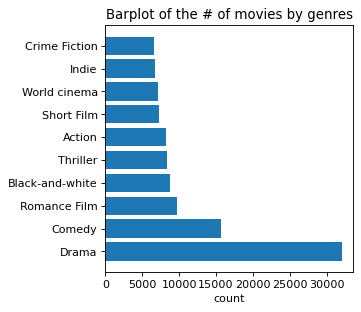

In [8]:
#Let's look at the genres of the movies
def get_count_genre(x):
    genre, count_genre = np.unique((list(chain.from_iterable(x))), return_counts=True)
    count_genre = pd.DataFrame({'genre': genre,'count': count_genre})
    return count_genre.sort_values(by=['count'], ascending=False) 

count_genre = get_count_genre(movie_metadata.genres)

#Let's only look at the top 15 genres
plt.figure(figsize=(4, 4), dpi=80)
plt.barh(count_genre.iloc[0:10].genre, count_genre.iloc[0:10]['count'])
plt.xlabel('count'); plt.title('Barplot of the # of movies by genres')
plt.show()

## Is the distribution the same accross decades? 
We see that the top genres evolved through the decades, but this makes sense since what movies likes certainly evolved with time. Moreover, tags such as black-and-white and silent movies disappear with the advance of technology. Nonetheless, some movies genres remain in the top accross almost all decades. For example, the genre drama, comedy, and action/adventure are very often present in the top 5 genres. Which also seems to be the case in the IMDb dataset. Therefore, we conclude that the sample of movies of the CMU corpus reflect the actual distribution of genres of all movies.

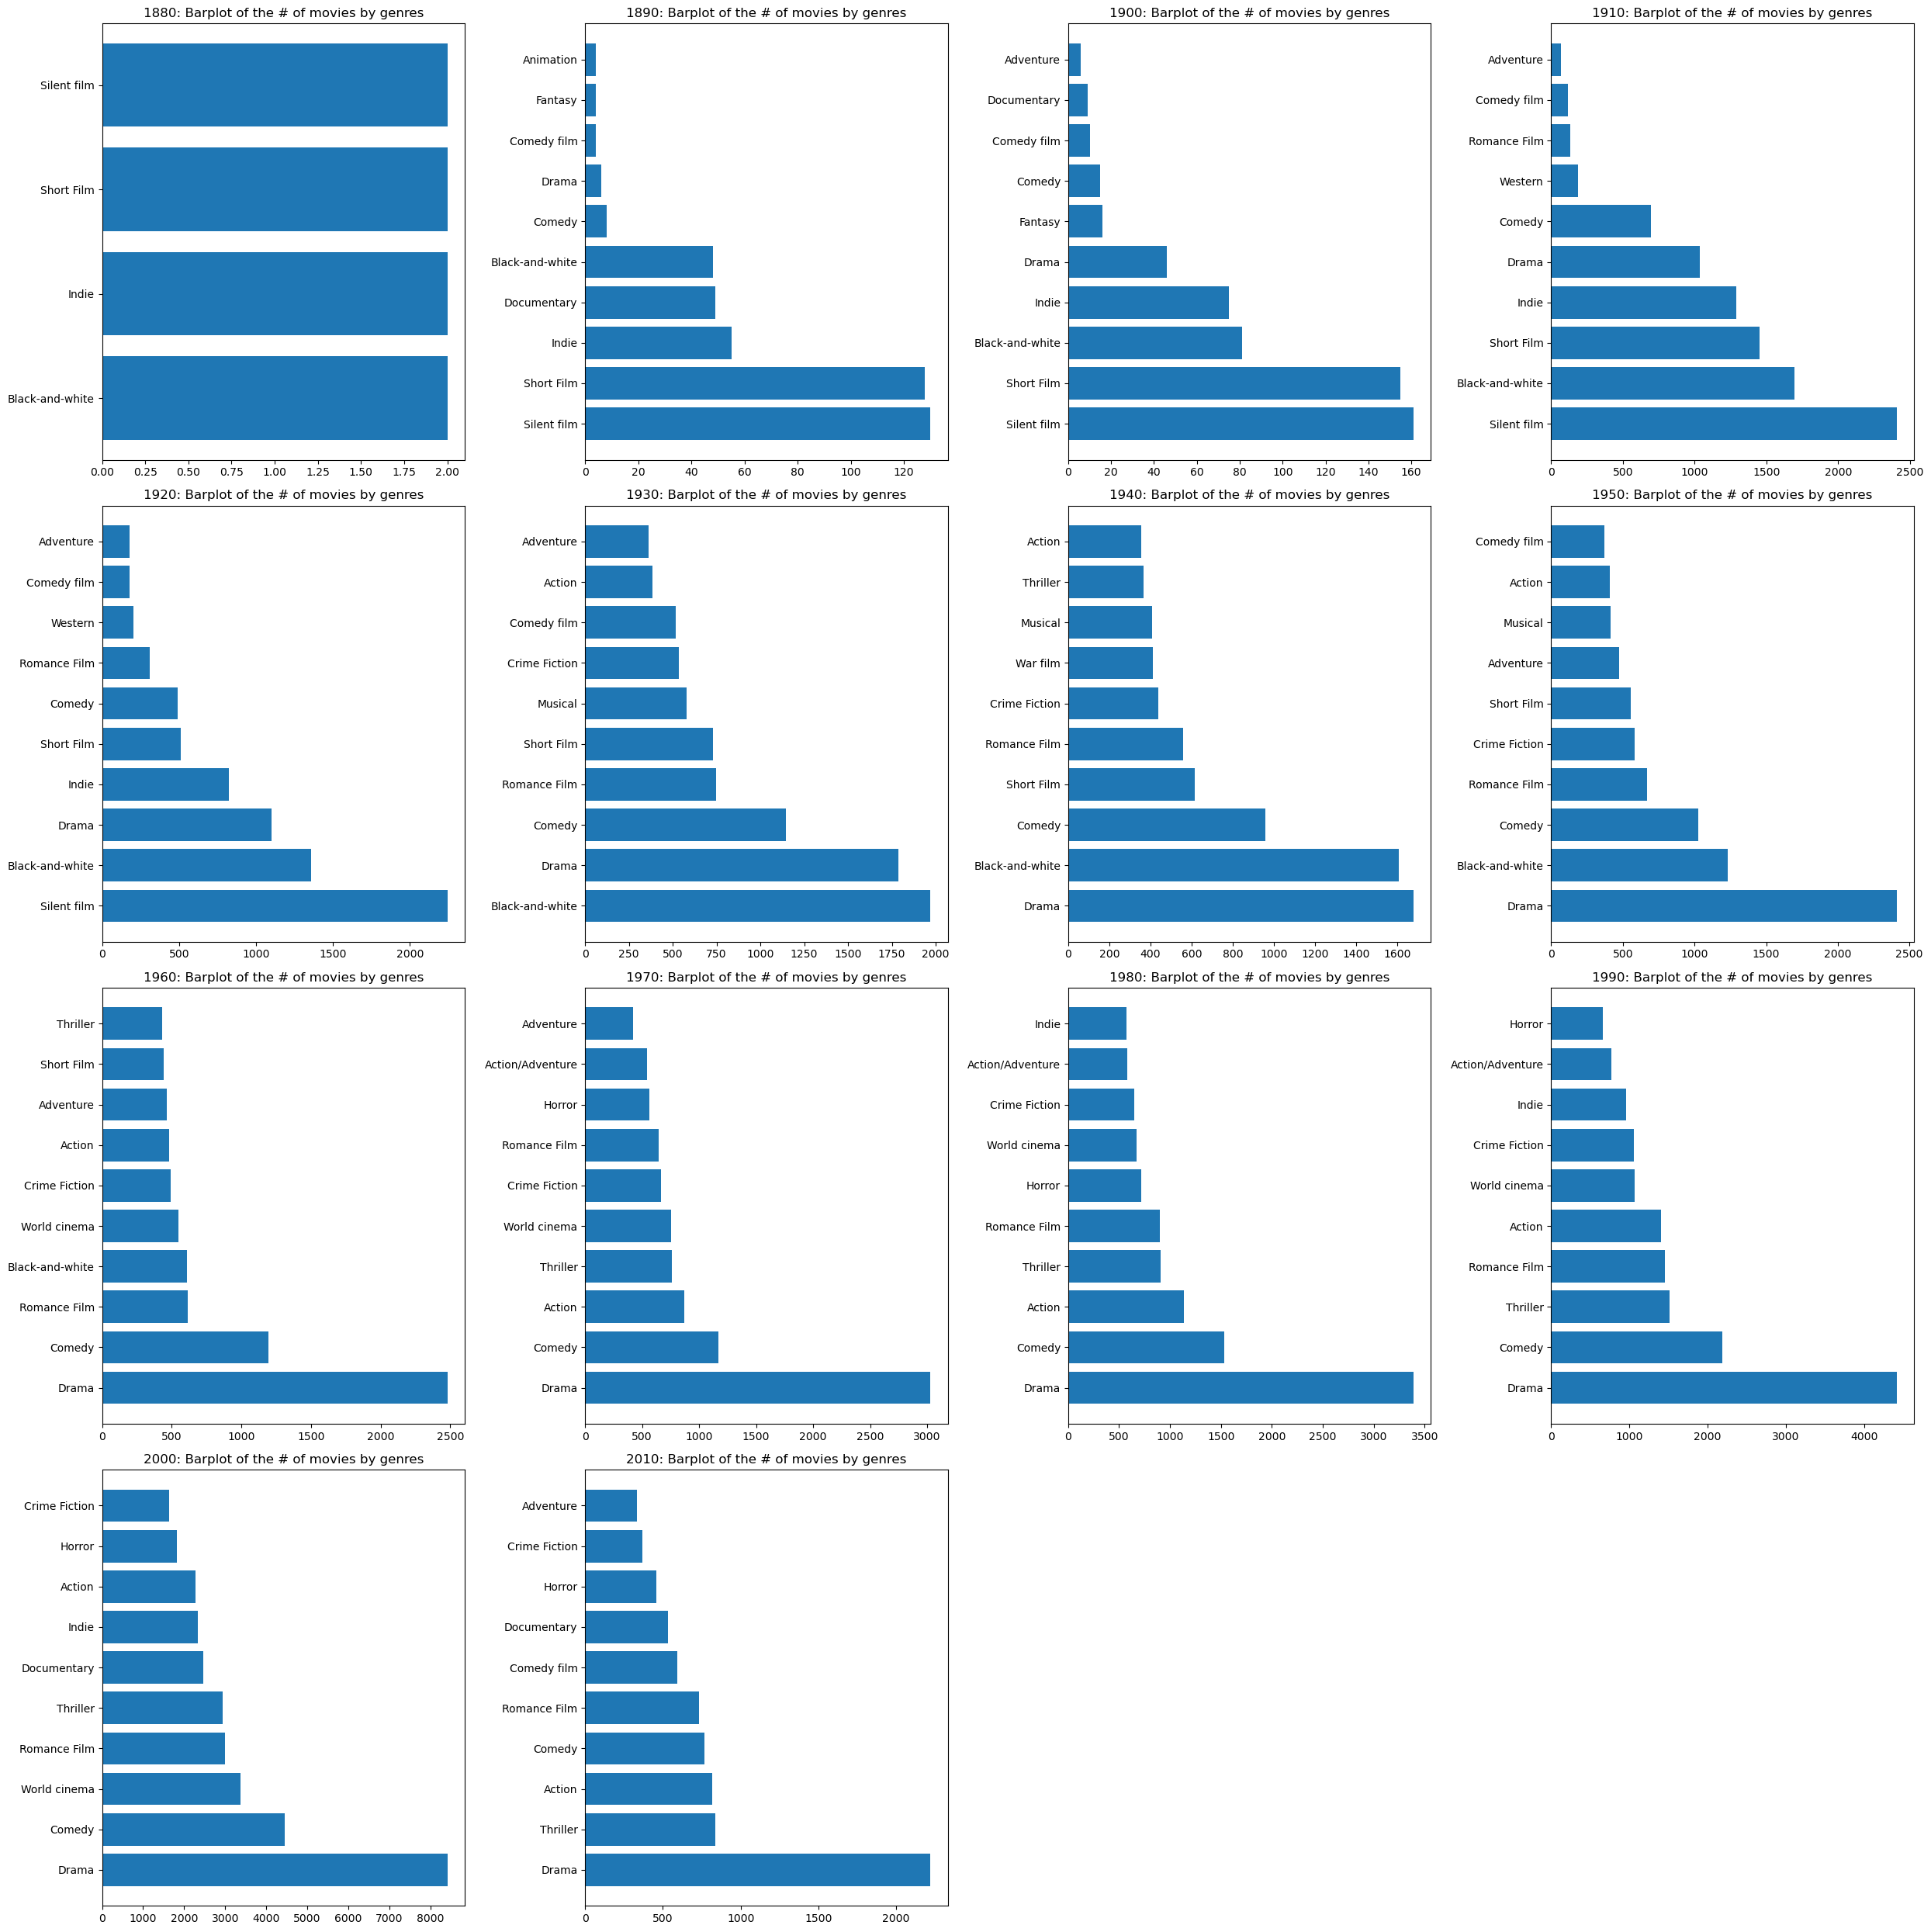

In [9]:
#Get count by decades
genre_count = movie_metadata.groupby((movie_metadata.release_date//10)*10).genres.apply(get_count_genre)

#Plot for each decade
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(25,25))
axes = axes.flatten()
for i, decade in enumerate(np.unique(movie_metadata.release_date//10*10)):
    
    if (genre_count.loc[decade].shape[0] >= 10):
        axes[i].barh(genre_count.loc[decade]['genre'].iloc[0:10], genre_count.loc[decade]['count'].iloc[0:10])
    else:
        axes[i].barh(genre_count.loc[decade]['genre'].values, genre_count.loc[decade]['count'])
    
    axes[i].set_title(str(decade) + ': Barplot of the # of movies by genres')

fig.delaxes(axes[14]); fig.delaxes(axes[15])
plt.tight_layout()
plt.show()

## Where were produced the movies?

The countries of production in CMU corpus is very diverse. However, The top producer appears to be the US, followed by India, and the UK. As of 2010 the top 3 was in order India, US and the UK [[1]].  But, since the movies were extracted from English wikipedia, it seems plausible that US movies would be overrepresented. Indeed, about 20% of English wikipedia editors are from the US, whereas only 3% are from India [[2]]. An editor from the US will most likely write an articles on a movie from the US and not on a indian movie. This explains the overrepresentation of US-produced movies.

Moreover, we decide here to only analyze the movies produce in the US since we want to study the portrayal of women in movies. And obviously gender equallity issues are largely influence by the culture. Therefore, we will focus our analysis on the US to have a homegeous culture.

[1]: https://www.screenaustralia.gov.au/fact-finders/international-context/world-rankings/in-the-archive/films-produced
[2]: https://en.wikipedia.org/wiki/Wikipedia:Who_writes_Wikipedia%3F

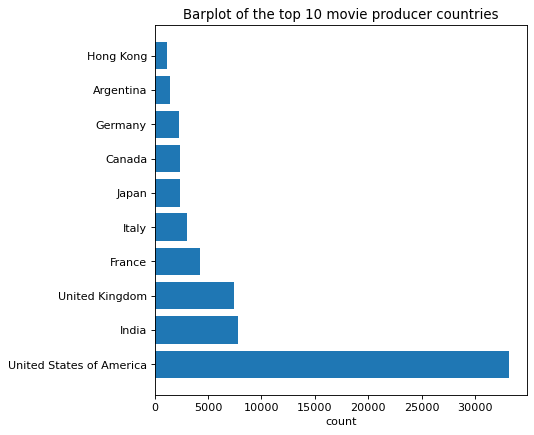

In [11]:
#Count for each country
country, count_country =  np.unique((list(chain.from_iterable(movie_metadata.country))),return_counts=True)
count_country = pd.DataFrame(count_country, index = country, columns=['count'])
count_country = count_country.sort_values(by=['count'], ascending=False)

#Let's only look at the top 10 producing movie country
plt.figure(figsize=(6, 6), dpi=80)
plt.barh(count_country.iloc[0:10].index, np.squeeze(count_country.iloc[0:10].values))
plt.xlabel('count'); plt.title('Barplot of the top 10 movie producer countries')
plt.show()

## Select only USA produced movies + since 1940

In [265]:
def check_USA_produced(countries):
    return any('United States of America' in country for country in countries)

#Select only movies produced in the US
mask_usa = [check_USA_produced(x) for x in movie_metadata.country]
usa_movie = movie_metadata[mask_usa]

usa_movie.head()

,movie_name,release_date,box_office,length,languages,country,genres
movie_ID,,,,,,,
975900,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
13696889,The Gangsters,1913,NaN,35.0,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Indie, Black-and-whi..."
10408933,Alexander's Ragtime Band,1938,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]"
175026,Sarah and Son,1930,NaN,86.0,[English Language],[United States of America],"[Drama, Black-and-white]"


## Show genres distribution with only USA+since 1940 -> is it the same 

# Data exploration character metadata focusing on gender

## Evolution of number of f vs m (normalized with respected with total number of movies)
### General + USA/1940

## Distribution of female and male characters by genre (use top 10)


## Distribution of female and male characters by genre (use top 10)
Focus on 2-3 genres that are typically more stereotypical for one of the gender
For example action (typical male) and romance (typical female)
Plot the difference between nb_male - nb_female and see if there is increase/decrease/constant
Difference is already normalised because sum nbr of movies

# Data exploration summaries <a name="summary"></a>

In [266]:
summaries['length'].describe()

count    42306.000000
mean       313.286437
std        319.313137
min          5.000000
25%         89.000000
50%        189.000000
75%        457.000000
max       4943.000000
Name: length, dtype: float64

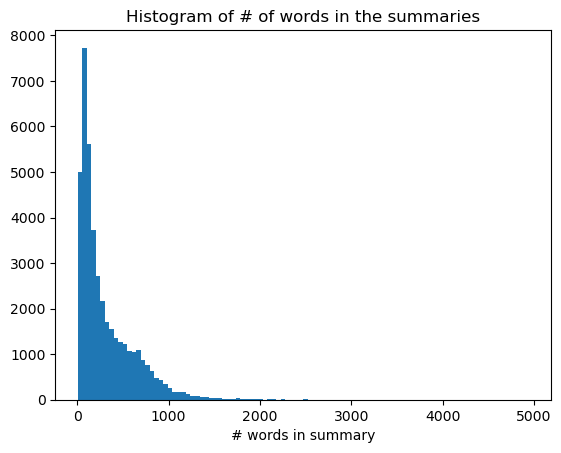

In [267]:
#Let's look at the distibution of the length of the summaries
plt.hist(summaries['length'],bins=100)
plt.xlabel('# words in summary'); plt.title('Histogram of # of words in the summaries')
plt.show()

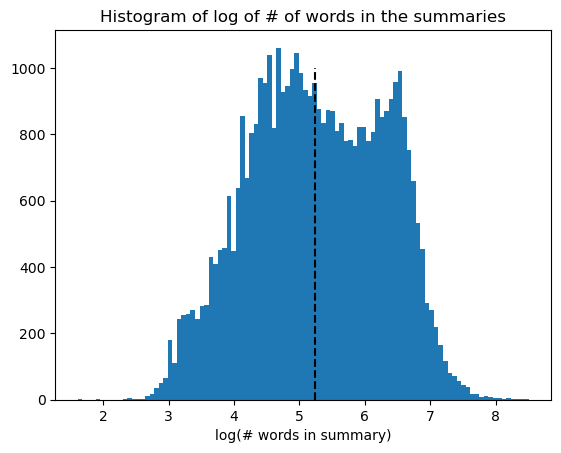

In [268]:
#The distribution is heavy tailed, apply log before binning
plt.hist(np.log(summaries['length']),bins=100)
plt.vlines(np.log(summaries['length']).median(), 0,1000, linestyles='dashed',color = 'black')
plt.xlabel('log(# words in summary)'); plt.title('Histogram of log of # of words in the summaries')
plt.show()

The dashed line is the median.

In [269]:
df = usa_movie

#Filter out summaries that are not in the set of movie of interest (USA + released after ...)
movie_interest = list(set(np.unique(summaries.index)).intersection(df.index.values))
summaries = summaries.loc[movie_interest]

In [271]:
summaries.describe()

,length
count,20240.000000
mean,365.637154
std,337.908667
min,7.000000
25%,101.000000
50%,246.000000
75%,565.000000
max,4283.000000


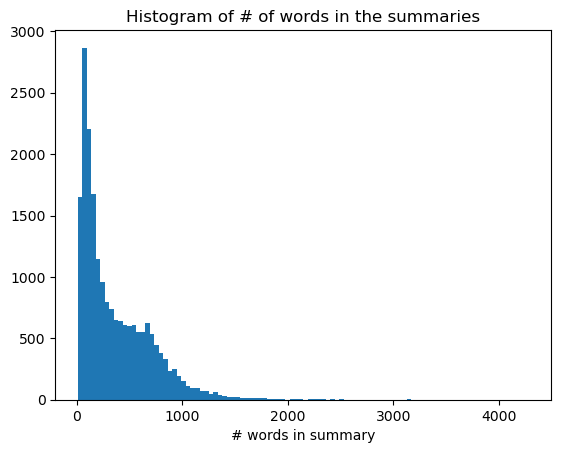

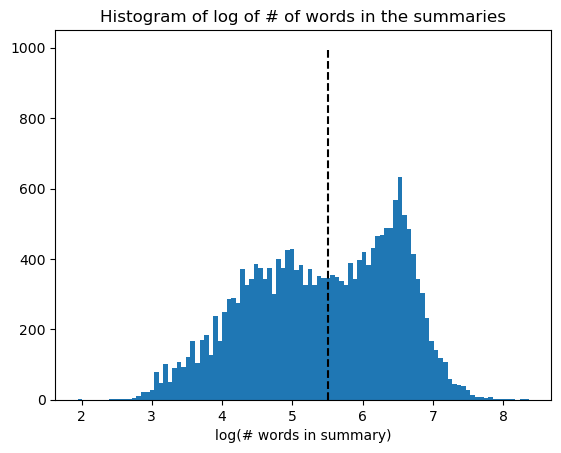

In [270]:
#Let's look at the distibution of the length of the summaries
plt.hist(summaries['length'],bins=100)
plt.xlabel('# words in summary'); plt.title('Histogram of # of words in the summaries')
plt.show()

#The distribution is heavy tailed, apply log before binning
plt.hist(np.log(summaries['length']),bins=100)
plt.vlines(np.log(summaries['length']).median(), 0,1000, linestyles='dashed',color = 'black')
plt.xlabel('log(# words in summary)'); plt.title('Histogram of log of # of words in the summaries')
plt.show()

## Justify number of words

# Summary NLP analysis pipeline <a name="pipeline"></a>

In [919]:
pd.DataFrame(columns=['name','mentions','gender','action_verb','passive_verb','description'])

,name,mentions,gender,action_verb,passive_verb,description


## Coreference Resolution using AllenNLP model <a name="coref"></a>

1. Resolve coreference using AllenNLP deep-learning based model and modified coref_resolved function.
2. Get gender of character in coreference cluster by looking at pronouns.

The behaviour of the coref_resolved function form AllenNLP need to be modified. Indeed, (list problem)

Some times by pronouns + ... Use modified version from https://github.com/NeuroSYS-pl/coreference-resolution + add function to order cluster of prediction -> remplace by way person is most often referred as

**What do we do with possive reference (...'s). Also count as occurence of character or don't remplace ?? For now don't replace**

In [7]:
nlp = spacy.load("en_core_web_sm")
text  = "In her first Reaping, 12-year-old Primrose Everdeen is chosen from District 12. Her older sister Katniss volunteers to take her place. Peeta Mellark, a baker\'s son who once gave Katniss bread when she was starving, is the other District 12 tribute. Katniss and Peeta are taken to the Capitol, accompanied by their frequently drunk mentor, past victor Haymitch Abernathy."

prediction = predictor.predict(document=text)
doc = nlp(text)

print('Original text: ', text)
print("")
print('Coref resolved: ', predictor.coref_resolved(text))

Original text:  In her first Reaping, 12-year-old Primrose Everdeen is chosen from District 12. Her older sister Katniss volunteers to take her place. Peeta Mellark, a baker's son who once gave Katniss bread when she was starving, is the other District 12 tribute. Katniss and Peeta are taken to the Capitol, accompanied by their frequently drunk mentor, past victor Haymitch Abernathy.

Coref resolved:  In her first Reaping, her is chosen from District 12. her's older sister Katniss volunteers to take her's place. Peeta Mellark, a baker's son who once gave Her older sister Katniss bread when Her older sister Katniss was starving, is the other District 12 tribute. Her older sister Katniss and Peeta Mellark, a baker's son who once gave Katniss bread when she was starving, are taken to the Capitol, accompanied by Katniss and Peeta's frequently drunk mentor, past victor Haymitch Abernathy.


In [3]:
def get_gender_from_coref(cluster, text):
    #Get text linked to indexes in cluster
    ref =  np.unique([" ".join(text[i[0]:i[1]+ 1]).lower() for i in cluster])
    
    #Define dict of gendered pronouns
    gendered_pronouns = dict([
        ('M', ['he','him','his','himself']),
        ('F', ['she','her','hers','herself'])
        ])
    
    gender = ''
    if any(y == x for x in ref for y in gendered_pronouns['M']): gender = 'M'
    if any(y == x for x in ref for y in gendered_pronouns['F']): gender = 'F'
    
    return gender

In [4]:
def order_coreference(cluster, text):
    #Get text linked to indexes in cluster
    ref =  pd.DataFrame([[" ".join(text[i[0]:i[1]+ 1]).lower(), i] for i in cluster])
    ref.columns = ['ref_text','ind']
    
    #Aggrate according to text, count number of occurence of each reference, and sort 
    ref = ref.groupby(ref['ref_text']).aggregate({'ref_text': 'count', 'ind': 'sum'})
    ref.index.name = None
    ref = ref.sort_values(by=['ref_text'], ascending=False) 

    
    #Order indexes in cluster
    cluster = list(chain(*ref.ind.values))
    cluster = list(zip(*(iter(cluster),) * 2))
    cluster = [list(x) for x in cluster]
    
    return cluster

In [5]:
#Modified Code from https://github.com/NeuroSYS-pl/coreference-resolution

from typing import List
from spacy.tokens import Doc, Span

def core_logic_part(document: Doc, coref: List[int], resolved: List[str], mention_span: Span):
    final_token = document[coref[1]]
    #if final_token.tag_ in ["PRP$", "POS"]:
        #resolved[coref[0]] = mention_span.text + "'s" + final_token.whitespace_
    #else:
    if not(final_token.tag_ in ["PRP$", "POS"]):
        resolved[coref[0]] = mention_span.text + final_token.whitespace_
    for i in range(coref[0] + 1, coref[1] + 1):
        resolved[i] = ""
    return resolved

def get_span_noun_indices(doc: Doc, cluster: List[List[int]]) -> List[int]:
    spans = [doc[span[0]:span[1]+1] for span in cluster]
    spans_pos = [[token.pos_ for token in span] for span in spans]
    span_noun_indices = [i for i, span_pos in enumerate(spans_pos)
        if any(pos in span_pos for pos in ['NOUN', 'PROPN'])]
    return span_noun_indices

def get_cluster_head(doc: Doc, cluster: List[List[int]], noun_indices: List[int]):
    head_idx = noun_indices[0]
    head_start, head_end = cluster[head_idx]
    head_span = doc[head_start:head_end+1]
    return head_span, [head_start, head_end]

def is_containing_other_spans(span: List[int], all_spans: List[List[int]]):
    return any([s[0] >= span[0] and s[1] <= span[1] and s != span for s in all_spans])

def improved_replace_corefs(document, clusters, text):
    resolved = list(tok.text_with_ws for tok in document)
    all_spans = [span for cluster in clusters for span in cluster]  # flattened list of all spans

    character = []
    for cluster in clusters:
        noun_indices = get_span_noun_indices(document, cluster)
        
        #Check if cluster contains gendered pronouns
        cluster_gender = get_gender_from_coref(cluster, text)

        if noun_indices:
            mention_span, mention = get_cluster_head(document, cluster, noun_indices)
            
            for coref in cluster:
                if coref != mention and not is_containing_other_spans(coref, all_spans):
                    core_logic_part(document, coref, resolved, mention_span)
            
            #Put in character dataframe all mention that are gendered
            if not(cluster_gender == ""):
                character.append([" ".join(text[mention[0]:mention[1]+ 1]).lower(), cluster_gender])
                
                    
    return "".join(resolved), character

In [8]:
clusters = list(pd.Series(prediction['clusters']).apply(order_coreference, args=(prediction['document'],)))
doc = nlp(text)

print('Original text: ', text)
print("")
coref_text, character = improved_replace_corefs(doc, clusters, prediction['document'])
print('Coref resolved: ', coref_text)

Original text:  In her first Reaping, 12-year-old Primrose Everdeen is chosen from District 12. Her older sister Katniss volunteers to take her place. Peeta Mellark, a baker's son who once gave Katniss bread when she was starving, is the other District 12 tribute. Katniss and Peeta are taken to the Capitol, accompanied by their frequently drunk mentor, past victor Haymitch Abernathy.

Coref resolved:  In her first Reaping, 12-year-old Primrose Everdeen is chosen from District 12. Her older sister Katniss volunteers to take her place. Peeta Mellark, a baker's son who once gave Katniss bread when Katniss was starving, is the other District 12 tribute. Katniss and Peeta are taken to the Capitol, accompanied by their frequently drunk mentor, past victor Haymitch Abernathy.


Get gender of character by looking for gendered pronouns. Need to get prounouns on its own since pronouns of other charcter sometime appear in descriptive reference of character.

In [15]:
text  = summaries.loc[31186339].summary
prediction = predictor.predict(document=text)

clusters = list(pd.Series(prediction['clusters']).apply(order_coreference, args=(prediction['document'],)))
doc = nlp(text)

C:\Users\alexi\anaconda3\lib\site-packages\allennlp\modules\token_embedders\pretrained_transformer_embedder.py:385: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  num_effective_segments = (seq_lengths + self._max_length - 1) // self._max_length


In [17]:
coref_text, character = improved_replace_corefs(doc, clusters, prediction['document'])
coref = pd.DataFrame(character, columns=['name','gender'])

coref

,name,gender
0,12 - year - old primrose everdeen,F
1,katniss,F
2,peeta,M
3,haymitch,M
4,rue,F
5,president snow,M
6,clove,F
7,thresh,M
8,"foxface , the girl from district 5 ,",F
9,cato,M


## Let's concatenante all these steps into a function for coreference resolution

In [29]:
def coreference_resoltion(text, nlp_pipeline, predictor):
    prediction = predictor.predict(document=text) 
    clusters = list(pd.Series(prediction['clusters']).apply(order_coreference, args=(prediction['document'],)))
    
    doc = nlp_pipeline(text)
    
    coref_text, character = improved_replace_corefs(doc, clusters, prediction['document'])
    character = pd.DataFrame(character, columns=['name','gender'])
    
    return coref_text, character

In [ ]:
nlp = spacy.load("en_core_web_sm")
model_url = "https://storage.googleapis.com/allennlp-public-models/coref-spanbert-large-2020.02.27.tar.gz"
predictor = Predictor.from_path(model_url)

In [70]:
summary = summaries.loc[31186339].summary

warnings.filterwarnings("ignore", category=DeprecationWarning)
coref_summary, coref_character = coreference_resoltion(summary, nlp, predictor)

C:\Users\alexi\anaconda3\lib\site-packages\allennlp\modules\token_embedders\pretrained_transformer_embedder.py:385: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  num_effective_segments = (seq_lengths + self._max_length - 1) // self._max_length


## Identify all characters in the text. <a name="NER"></a>


**How to keep only name in Coref**

**Problem with character name containing other character ie. Katniss' father**

### Using the RER module from spacy

On it's own the NER module form scapy misses a lot of mention of person.
There's * named character in text and 31 are found by the spacy (..%).

In [31]:
nlp = spacy.load("en_core_web_sm")

text = coref_text
doc = nlp(text)
    
print(len([(X.text, X.label_) for X in doc.ents if X.label_== 'PERSON' ]))

31


### Add entity ruler with all character name

To improve the accuracy we add an entity ruler to spacy with all character name, the rest of person in summaries are recognize by the scapy NER module. Each custom names set is specific for a movie to avoid confusion. Not all character name are common name ie. "Candy".

Add column with unique part of name, 

**also remove common word ?? i.e The, Mrs., ...**

** DOn't remove unique name**

In [51]:
#Get unique name for each character
#Remove non-unique part of character name
character = character_metadata.loc[31186339][:]#[:-3]

def get_unique_name (name, list_names):
    name = name.lower()
    mask_unique_name = np.where([list_names.count(x) < 2 for x in name.split()])[0]
    
    return " ".join(np.array(name.split())[mask_unique_name])

name_metadata = list(chain(*[x.lower().split() for x in character.name]))
character['name'] = character.name.apply(get_unique_name, args=(name_metadata,))

character.head()

,name,gender,age
movie_ID,,,
31186339,katniss,F,21.0
31186339,peeta mellark,M,19.0
31186339,effie trinket,F,38.0
31186339,gale hawthorne,M,22.0
31186339,haymitch abernathy,M,50.0


Link character metadata to coreference characters

In [62]:
def find_whole_word(string:str,list_words:list):
    return any(y == x for x in string.lower().split() for y in list_words)

def check_coref_in_metadata(coref_charac, metadata):
    return pd.Series({'name': coref_charac, 'ind': np.where(metadata.apply(lambda row : find_whole_word(coref_charac, row.unique_name), axis=1))[0]})

def add_character_from_coref(coref, metadata):
    
    #Add to metadata character found by coreference resolution
    split_name = [x.split() for x in metadata.name]
    unique_names = list(chain(*split_name))
    
    character_to_add = np.logical_not(list(coref['name'].apply(find_whole_word, args=(unique_names, ))))
    character_to_add = pd.DataFrame(coref[character_to_add])
    character_to_add.name = [x.split(', ')[0] for x in character_to_add.name]
    
    return character_to_add

In [123]:
to_add = add_character_from_coref(coref,character)
character = pd.concat([character, to_add], sort=False)

character

,name,gender,age
31186339,katniss,F,21.0
31186339,peeta mellark,M,19.0
31186339,effie trinket,F,38.0
31186339,gale hawthorne,M,22.0
31186339,haymitch abernathy,M,50.0
31186339,clove,F,15.0
31186339,caesar flickerman,M,51.0
31186339,primrose,F,11.0
31186339,president snow,M,76.0
31186339,cato,M,19.0


Create pattern for the entity_ruler from character list

In [72]:
#Create pattern from character list
#character = character_metadata.loc[31186339].name.values[:-3]

#Need to rewrite this, not good enough yet
def get_patterns(character):
    patterns = []
    for c in character.name:
        split_name = c.split()
        for i in split_name:
             patterns.append({"label": "PERSON", "pattern": [{"LOWER": i.lower()}], "id": c})
        if (len(split_name) > 1):
            patterns.append(({"label": "PERSON", "pattern": [{"LOWER": split_name[0].lower()},{"LOWER": split_name[1].lower()}], "id": c}))
    return patterns

In [124]:
nlp = spacy.load("en_core_web_sm")
ruler = nlp.add_pipe("entity_ruler", before ='ner')
nlp.add_pipe("merge_entities")

patterns = get_patterns(character)

ruler.add_patterns(patterns)

In [125]:
text = coref_text
doc = nlp(text)

print(len([X.text for X in doc.ents if X.label_== 'PERSON' ]))

115


In [137]:
def identify_character(character_metadata, character_coref):
    #Get name and gender of character form metadata. Only keep the unique part of the name.
    name_metadata = list(chain(*[x.lower().split() for x in character_metadata.name]))
    character_metadata['name'] = character_metadata.name.apply(get_unique_name, args=(name_metadata,))
    
    #Check if the coreference resolution indentified a character not in the metadata
    #If yes add it to the character metadata
    to_add = add_character_from_coref(character_coref ,character_metadata)
    character = pd.concat([character_metadata, to_add], sort=False)
    
    return character

def add_character_entity_ruler_to_nlp(nlp, character):
    ruler = nlp.add_pipe("entity_ruler", before ='ner')
    nlp.add_pipe("merge_entities")

    patterns = get_patterns(character)

    ruler.add_patterns(patterns)
    
    return nlp

In [138]:
nlp = spacy.load("en_core_web_sm")
c_metadata = character_metadata.loc[31186339][:]

character = identify_character(c_metadata, coref_character)
nlp = add_character_entity_ruler_to_nlp(nlp, character)
character = character.set_index('name')

## Finally, we can now run the summary trough the nlp pipeline! To get the verb and adjective associated with the characters.

In [229]:
text =  summaries.loc[31186339].summary
doc = nlp(text)
    
spacy.displacy.render(doc, style='dep')

In [250]:
text = 'Ralph her father is seen walking'
doc = nlp(text)
    
spacy.displacy.render(doc, style='dep')

coref_text, character = improved_replace_corefs(doc, clusters, prediction['document'])
print('Coref resolved: ', coref_text)

Coref resolved:  Ralph her father is seen walking


In [232]:
active = []
for token in doc:
    if token.pos_ == 'VERB':
        for child in token.children:
            
            if child.dep_ == 'nsubj':
                if child.ent_type_ == 'PERSON':
                    active.append([token.lemma_, child.text.lower()])
                    for x in child.children:
                        if x.dep_ == 'conj' and x.ent_type_ == 'PERSON':
                            active.append([token.lemma_, x.text.lower()])
                else:
                    nsubj = list(child.children)
                    #while list(nsubj):
                        #1
                    #while list(nsubj):
                        #for x in nsubj:
                            #if x.ent_type_ == 'PERSON':

                            #nsubj = nsubj.children
            #else if child.dep == 'nsubj':
                1
            #else if child.dep == 'agent':
                1
active              

[['reveal', 'peeta'],
 ['mean', 'peeta'],
 ['survive', 'katniss'],
 ['form', 'peeta'],
 ['draw', 'rue'],
 ['drop', 'katniss'],
 ['care', 'rue'],
 ['draw', 'katniss'],
 ['kill', 'cato'],
 ['run', 'katniss'],
 ['trap', 'rue'],
 ['throw', 'marvel'],
 ['shoot', 'katniss'],
 ['beg', 'peeta'],
 ['promise', 'katniss'],
 ['ambush', 'clove'],
 ['kill', 'thresh'],
 ['die', 'foxface'],
 ['change', 'crane'],
 ['wound', 'katniss'],
 ['shoot', 'katniss'],
 ['tell', 'peeta'],
 ['warn', 'haymitch'],
 ['consider', 'president snow']]

In [166]:
pattern = [{'POS':'PROPN'},{'POS':'AUX'},{'POS':'VERB'}]

verb_phrases = textacy.extract.token_matches(doc, patterns=pattern)
list(verb_phrases)

[Everdeen is chosen, Katniss was starving, Peeta are taken]

In [117]:
def get_(doc):
    for token in doc:
        compounds = [child.text for child in token.children]
        print(compounds)
    
    return " ".join(compounds) + " " + token.text 

component(doc)

['Reaping']
[]
[]
['her', 'first', ',']
[]
[]
[]
['12-year-old', 'Primrose']
[]
['In', 'Everdeen', 'is', 'from', '.']
['District']
['12']
[]
[]
[]
[]
['Her', 'older', 'volunteers', 'take', '.']
[]
['Katniss']
[]
['to', 'place']
[]
['her']
[]
[',', 'son', ',']
[]
[]
['a', "'s"]
[]
['baker', 'gave']
[]
[]
['who', 'once', 'bread', 'starving']
[]
['Katniss']
[]
[]
[]
['when', 'Katniss', 'was']
[]
['Peeta Mellark', 'tribute', '.']
[]
[]
[]
[]
['the', 'other', 'District', '12']
[]
['and', 'Peeta']
[]
[]
[]
['Katniss', 'are', 'to', ',', 'accompanied', '.']
['Capitol']
[]
['the']
[]
['by']
['mentor']
[]
[]
['frequently']
['their', 'drunk', ',', 'Haymitch Abernathy']
[]
[]
[]
['past', 'victor']
[]


' .'

In [139]:
named_ent = [X.text if X.id_ == '' else X.id_ for X in doc.ents if X.label_== 'PERSON' ]

#Get count of mentions of character in summary
c, counts = np.unique(named_ent, return_counts = True)
df = pd.DataFrame(counts, index = c, columns=['mention'])


df = df.sort_values(by=['mention'], ascending=False)
df

,mention
katniss,47
peeta mellark,28
rue,11
cato,6
haymitch abernathy,4
seneca crane,4
clove,3
thresh,3
foxface,2
president snow,2


### Let's merge the info from spacy with the character metadata

In [140]:
df = pd.merge(df,character, how='left', left_index=True, right_index=True)
df

,mention,gender,age
katniss,47,F,21.0
peeta mellark,28,M,19.0
rue,11,F,13.0
cato,6,M,19.0
haymitch abernathy,4,M,50.0
seneca crane,4,M,33.0
clove,3,F,15.0
thresh,3,M,NaN
foxface,2,F,NaN
president snow,2,M,76.0
